# CS 4496/7496 Character Animation (Fall 2021)
Copyright (c) Georgia Institute of Technology


---


## Project 3: Tinkertoy (due 10/29/2021, 11:59PM)

![TinkerToy Picture](http://cc.gatech.edu/~sha9/images/tinkertoy.jpg)

Your task is to simulate two beads under gravity. One bead must stay on a circular wire and the second bead is connected to the first one by a fixed-length rod. You will implement one constraint that keeps a bead on the circle and another that keeps two beads a fixed distance apart. Your program should simulate the motion of the beads under gravity and should draw the beads as they move. 

**Reference: 04_ConstrDyn.pdf **

In [145]:
# import necessary libraries
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# 1. Constrained system
Define the initial state of the system, which consists of the positions and velocities of the two beads. The first bead is at (0.6, 0.8) initially, and attached to a circle of radius 1, centered at the origin. The second bead is at (0.6, 0.3) initially, connected to the first bead by a rod of length 0.5. Both particles have zero initial velocity.

In [146]:
# number of beads in the system
n_particles = 2

# number of constraints in the system
n_constraints = 2

positions, velocities = None, None # placeholders
constraint_values = list()

def initialize():
  global positions, velocities, constraint_values
  # positions: column vector of size 2 * n_particles, concatenation of all positions of the beads
  positions = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1)
  # velocities: column vector of size 2 * n_particles, concatenation of all velocities of the beads
  velocities = np.array([0., 0., 0., 0.]).reshape(-1, 1)
  # constraint_values: a list of constraint values over time
  constraint_values = list()

Given the positions and velocities of the particles, evaluate the value of constraints, C(x). C[0] is the first constraint that keeps the first particple at a circular wire (radius 1.0, center at origin). C[1] is the second constraint that maintains the distance between two particles to be 0.5. Please fill two numbers. ** **write your code below 15 pts)**  **

In [147]:
def eval_C(positions, velocities):
  """Evaluates the value of constraints, C(x)."""
  C = np.zeros([n_constraints, 1])
  # Student code starts here
  
  x1 = np.array([positions[0], positions[1]]) #2x1
  x1copy = x1.reshape(1,2) #1x2
  x2 = np.array([positions[2], positions[3]]) #2x1
  x2copy = x2.reshape(1,2) #1x2

  # (1/2)x1 * x1 - (1/2)r^2, dim: 1x2 @ 2x1 = 1x1
  C[0] = 1/2 * x1copy @ x1 - 1/2 * 1**2 
  #(1/2)(x1-x2)*(x1-x2)-(1/2)d^2, dim: 1x2 @ 2x1 = 1x1
  C[1] = 1/2 * (x1copy - x2copy) @ (x1 - x2) - 1/2 * 0.5**2 

  # Student code ends here
  return C

Cdot is its time derivative. Use the chain rule (dC/dt = dC/dX dX/dt, X is position and \dot{X} is velocity) to compute the time derivative of the first and second constraints. ** **write your code below (15 pts)**  **


In [148]:
def eval_Cdot(positions, velocities):
  """Evaluates the time derivative of constraints, Cdot(x)."""
  Cdot = np.zeros([n_constraints, 1])
  # Student code starts here

  #dX/dt is velocity, dim: 2x1

  x1 = np.array([positions[0], positions[1]]) #2x1, x1 position
  x1copy = np.array([positions[0], positions[1]]).reshape(1,2) #1x2
  x2 = np.array([positions[2], positions[3]]) #2x1, x2 position
  x2copy = np.array([positions[2], positions[3]]).reshape(1,2) #1x2

  v1 = np.array([velocities[0], velocities[1]]) #2x1, x1 velocity
  v2 = np.array([velocities[2], velocities[3]]) #2x1, x2 velocity

  #x1 position x velocity, 1x2 @ 2x1
  Cdot[0] = x1copy @ v1 #1x1
  #(x1-x2) @ (x1dot - x2dot = v1-v2), 1x2 @ 2x1
  Cdot[1] = (x1copy - x2copy) @ (v1-v2) #1x1
  
  # Student code ends here
  return Cdot


The below is the simple unit test. The test is design to verify whether 1) C and Cdots are zero when it is at the valid state and 2) C and Cdots are non zero when we perturb the state. Can you pass the tests?

In [149]:
# Simple unit tests
p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1), np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
assert(np.allclose(eval_C(p0, v0), np.array([[0.0], [0.0]])))
assert(not np.allclose(eval_C(p0 + 0.1, v0), np.array([[0.0], [0.0]])))
assert(np.allclose(eval_Cdot(p0, v0), np.array([[0.0], [0.0]])))
assert(not np.allclose(eval_Cdot(p0, v0 + 0.1), np.array([[0.0], [0.0]])))

For simplicity, the mass of the beads are all set to 1. Therefore, the mass matrix and inverse mass matrix are simply identity matrices of size 2 * n_particles.

In [150]:
M = np.eye(n_particles * 2)
# np.eye returns the identity matrix.
# We can set the mass values, like M[0, 0] = 1.0, M[1, 1] = 1.0, ... M[3, 3] = 1.0
# but not necessary because all the masses are assumed to be zero.
W = np.eye(n_particles * 2)  

The external forces in this system are gravities on the beads. The external force vector is defined below.

In [151]:
 g = -10 # approximated value, instead of -9.8
 Q = M @ np.tile([0, g], n_particles).reshape(-1, 1)
 print("The external force vector = \n", Q)
 

The external force vector = 
 [[  0.]
 [-10.]
 [  0.]
 [-10.]]


Here, evaluate the value of the Jacobian matrix and its time derivative. Complete the code below. (hint: consider the dimenions of each matrix) ** **write your code below (15 pts each)**  **

In [152]:
def eval_J(positions, velocities):
  """Evaluates the value of the Jacobian matrix, J."""
  J = np.zeros([n_constraints, n_particles * 2]) # fill in the correct dimension of J
  # Student code starts here
  #dim: 2x4, first row = [∂C1/∂x1,∂C1/∂y1,∂C1/∂x2,∂C1/∂y2]
  x1 = np.array([positions[0], positions[1]]).reshape(1,2) #x1 position
  x2 = np.array([positions[2], positions[3]]).reshape(1,2) #x2 position

  first = x1
  second = np.array([0,0]).reshape(1,2) 
  third = x1 - x2
  fourth = -(x1-x2)

  #J = [[x1, 0], [(x1-x2), -(x1-x2)]]
  J = np.array([first, second, third, fourth]).reshape(2,4)

  # Student code ends here
  return J

In [153]:
def eval_Jdot(positions, velocities):
  """Evaluates the time derivative of the Jacobian matrix, J."""
  Jdot = np.zeros([n_constraints, n_particles * 2]) # fill in the correct dimension of Jdot
  # Student code starts here
  #dim: 2x4
  v1 = np.array([velocities[0], velocities[1]]).reshape(1,2) #x1 velocity
  v2 = np.array([velocities[2], velocities[3]]).reshape(1,2) #x2 velocity

  first = v1
  second = np.array([0,0]).reshape(1,2)
  third = v1 - v2
  fourth = -(v1-v2)

  #J = [[v1, 0], [(v1-v2), -(v1-v2)]]
  Jdot = np.array([first, second, third, fourth]).reshape(2,4)
  
  # Student code ends here
  return Jdot

Let's see if your codes can pass the unit test. By definition, J is a partial derivative of C with respect to x and Jdot is a partial derivative of Cdot with respect to x. The below test computes J and Jdot using numerical approximation (https://en.wikipedia.org/wiki/Finite_difference) and compares with your implementation. Please use this part as a sanity check.

In [154]:
# Unit tests for J and Jdot
# By the definition, J is a partial derivative of C.
# And Jdot is a partial derivative of Cdot.
# Can we check them with a numerical approximation method?
p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1), np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
# p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]), np.array([0.8, -0.6, 0.0, 0.0])

h = 0.001
J = eval_J(p0, v0)
Jdot = eval_Jdot(p0, v0)
assert(J.shape == (n_constraints, n_particles * 2))
assert(Jdot.shape == (n_constraints, n_particles * 2))

for i in range(n_particles * 2):
  delta = np.zeros([n_particles * 2, 1])
  delta[i, 0] = h

  # Perturb the i th element of p0 by h
  Cm = eval_C(p0 - delta, v0)
  Cp = eval_C(p0 + delta, v0)
  dC_dpi = (Cp - Cm) / (2 * h) # Numerical approximation with finite difference
  assert(np.allclose(dC_dpi, J[:, i].reshape(-1, 1)))

  # Perturb the i th element of p0 by h
  Cdotm = eval_Cdot(p0 - delta, v0)
  Cdotp = eval_Cdot(p0 + delta, v0)
  dCdot_dpi = (Cdotp - Cdotm) / (2 * h) # Numerical approximation with finite difference
  assert(np.allclose(dCdot_dpi, Jdot[:, i].reshape(-1, 1)))  

Find the derivatives of positions and velocities of all particles at the current frame. You need to calculate 1) the Lagrangian multipliers with feedback terms and 2) the forces due to constraints, and then 3) the derivatives of positions and velocities of the particles. (hint: keep checking dimensions of each component, the Lagrangian multipliers, constraint forces, and so on) (hint #2: what are the definitions of positions and velocities?) ** **write your code below (15 pts each)**  **

In [155]:
def eval_derivative(positions, velocities):
  global M, W, Q
  C = eval_C(positions, velocities)
  Cdot = eval_Cdot(positions, velocities)
  J = eval_J(positions, velocities)
  Jdot = eval_Jdot(positions, velocities)

  positions_derivative = np.zeros(positions.shape)
  velocities_derivative = np.zeros(velocities.shape)

  # Feedback terms parameters
  # You can tune these values
  ks = 1
  kd = 1
  #ks = 100
  #kd = 100
  # Student code starts here
  
  # 1) Compute the Lagrangian multipliers w/ feedback terms
  # You have to extend the equation in page 34, 04_ConstrDyn.pdf.
  # The original equation is JWJ^T lambda = -Jdot qdot - JWQ
  # The right hand side needs additional feedback terms:
  #  JWJ^T lambda = -Jdot qdot - JWQ -ks C - kd Cdot.
  # Solve for lambda with np.linalg.inv or np.linalg.solve
  # Check the derivation by yourself!

  #JWJ^T
  left = J @ W @ (np.transpose(J))
  #-Jdot qdot - JWQ -ks C - kd Cdot
  right = -Jdot @ velocities - J @ W @ Q - ks * C - kd * Cdot 
  #solve for lambda
  lam = np.linalg.solve(left, right)

  # 2) Compute the constraint force, Qhat = J^T lambda
  Qhat = np.transpose(J) @ lam
  # Compute positions_derivative and velocities_derivative
  positions_derivative = velocities
  velocities_derivative = W @ (Qhat + Q) # Assume Qhat is the constraint force

  # Student code ends here
  assert(positions_derivative.shape == positions.shape)
  assert(velocities_derivative.shape == velocities.shape)
  return positions_derivative, velocities_derivative


Now we need the integrators.
Two integrators, Explicit Euler and Midpoint methods are given.

In [156]:
def explicit_euler(dt):
  """Advances the positions and velocities by dt using the Euler method."""
  global positions, velocities
  # modifies positions, velocities
  dp, dv = eval_derivative(positions, velocities)
  positions += dt * dp
  velocities += dt * dv
  
def mid_point(dt):
  """Advances the positions and velocities by dt using the Midpoint method."""
  global positions, velocities
  # modifies positions, velocities
  dp, dv = eval_derivative(positions, velocities)
  mp = positions + dt * dp * 0.5
  mv = velocities + dt * dv * 0.5
  dp, dv = eval_derivative(mp, mv)
  positions += dt * dp
  velocities += dt * dv 

def update(dt):
  global positions, velocities, constraint_values
  # **** change this line if you want to switch the integrator ****
  # explicit_euler(dt)
  mid_point(dt)

  # record the constraint values
  C = eval_C(positions, velocities)
  constraint_values.append(C.reshape(-1))


Function calls for creating animations. Do not modify this part (unless you are working on extra questions).

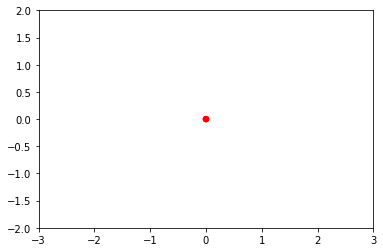

In [157]:
n = n_particles
# Figure and shape placeholders
fig, ax = plt.subplots()
ax.set_xlim((-3.0, 3.0))
ax.set_ylim((-2.0, 2.0))
circle, = ax.plot([], [], 'b')
rod, = ax.plot([], [], 'k')
beads = []
for i in range(n):
  bead = plt.Circle((0, 0), 0.05, color='r')
  beads.append(bead)
  ax.add_artist(bead)

# plot circle, rod and beads
def plot_scene():
  circle.set_data(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)))
  rod.set_data([positions[0], positions[2]], [positions[1], positions[3]])
  for i in range(n):
    beads[i].set_center(positions[2*i:2*i+2])

# Called before the first frame
def init_animation():
  plot_scene()
  return []

# Called every frame
def animate(i):
  if i % 25 == 0:
    print("Generating frame #%d..." % i)
  update(0.01)
  #explicit_euler(0.01)
  #mid_point(0.01)
  plot_scene()
  return []




Generate your animation!

In [159]:
initialize()
anim = animation.FuncAnimation(fig, animate, init_func=init_animation, frames=500, interval=20, blit=False)
HTML(anim.to_html5_video())

Generating frame #0...
Generating frame #25...
Generating frame #50...
Generating frame #75...
Generating frame #100...
Generating frame #125...
Generating frame #150...
Generating frame #175...
Generating frame #200...
Generating frame #225...
Generating frame #250...
Generating frame #275...
Generating frame #300...
Generating frame #325...
Generating frame #350...
Generating frame #375...
Generating frame #400...
Generating frame #425...
Generating frame #450...
Generating frame #475...


Let's plot both constraint values. Are they near zero during the entire simulation?

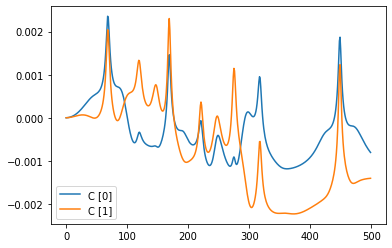

In [160]:
constraint_values = np.array(constraint_values)
plt.plot(constraint_values[:, 0], label="C [0]")
plt.plot(constraint_values[:, 1], label="C [1]")
plt.legend()

Now it's time for discussion. Repeat the experiments with different integrators (Euler/Midpoint) and different feedback terms (ks/kd). What is the best configuration that keeps the maximum C values low? ** **write your answer below (10 pts)** **

I first repeated the experiment with the Euler method, and the beads started to behave abnormally. It started ok with the first particle attached to the circle at the beginning, but then the beads started to go off the circle, and eventually, they went completely off track.

Secondly, I repeated using the midpoint method in which the beads behaved as expected, and the constraints seemed to be working properly; the first particle was attached to the circle the entire time, and the second particle was connected to the first one at a 0.5 distance.

Lastly, I tuned the feedback terms to see whether changing ks and kd values led to better results (C values close to 0) or not.
Keeping the feedback terms at a default value of 1 led to this result:

 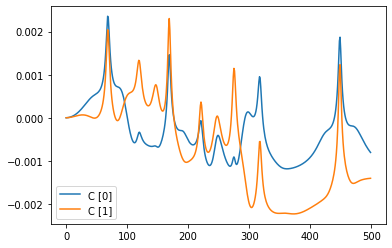

Since the C values are low (< 0.002), the system was already pretty stable. 


---




Changing the feedback terms to 0.5 actually decreased the stability of the simulation as shown below:

 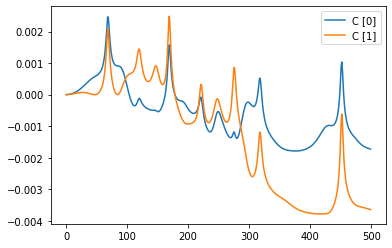

The C[1] values started to fall below -0.002 after 300th frame. 


---



Similar situation happened when I tuned the ks value to 1 and the kd value to 0.5.

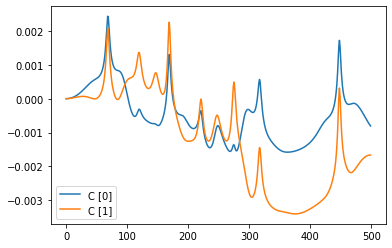

The C[1] values still fell below -0.002 after the 300th frame, but it did not fall as much as before when both terms were set to 0.5. 


---


I changed the ks value to 0.5 and the kd value to 1, and this change led to more stable system than when the ks was set to 1 and the kd was set to 0.5.

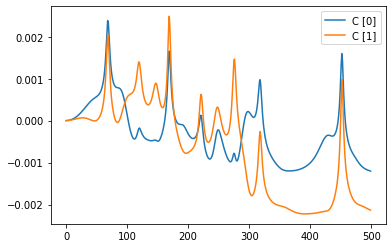


---


By running the experiment with different feedback terms, I realized that larger feedback terms led to better results in terms of C values being near 0, so I increased the ks and kd values to 1.5, and the result was as shown: 

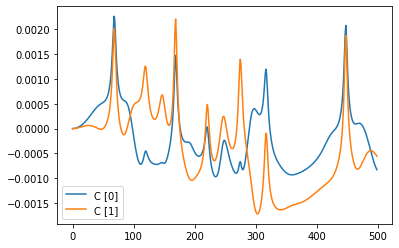

This result was by far the best result I have gotten from changing the feedback terms. 

---
After experimenting with different feedback terms, I wondered what the plot would look like if I set the feedback terms to a very large number, so I set both ks and kd to 100 which led to the result below: 

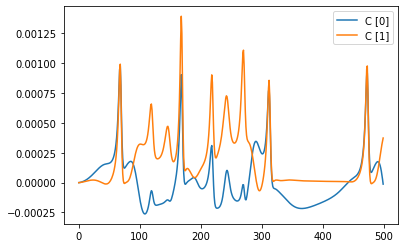

Surprisingly, the C values were very close to 0 (< -0.00025). This result made me think that the larger the feedback terms, the closer C values are to 0. However, from reading the Professor's comments on large feedback terms, I learned that high feedback terms do not necessarily imply better results because they can make the system stiff. As a conclusion, I learned that although larger feedback terms tend to yield lower C values, it does not always mean that their results are better and that one needs to find a right value for the feedback terms that not just keeps the C values near 0 but also yields a stable system. 

# 2. Extra points

2.1. Apply extra forces a few times during the simulation. Don't forget to visualize the forces as lines. You are expected to directly modify the above code (hint: update the global force vector Q with respect to time. You can modify either update or animate functions). ** **edit the above code directly and explain your implmenetation below (3 pts)**  **


(explain your implementation here)

2.2. Implement the RK4 solver and verify that it is better than other methods. ** **edit the above code directly and explain your implmenetation below (2 pts)**  **

(explain your implementation here)

2.3. Implement additional types of constraints for the tinkertoy (e.g. an additional bead is connected to the second bead or three beads should always form an equilateral triangle). If the constraint outputs more than a single scalar, you need to modify the indexing scheme for the global matrices and vectors so that the constraint evaluations and derivatives are stored in the correct places. (hint: here's an inspiring example: https://youtu.be/ShtiCeJWIxw) ** **edit the above code directly and explain your implmenetation below (5 pts)**  **

(explain your implementation here)

# 3. Research Project.
The task for this research project is basically the same as the extra question 2.3. But I want to see more creativity and automation here. Can you develop a new type of constraints, such as parabola, ellipse, or sinusoidal curves? Instead of hand-coding all the derivatives and Jacobians, can you automatically derive functions using symbolic computation (e.g., SymPy: https://www.sympy.org/)? Then we can simply type constraints, like C[0] = x^2 - 1.0 and C[1] = (x1 - x2)^2 - 0.5^2 = 0, and your symbolic engine will compute all the Cdot, J, and Jdot. Can you use your symbolic engine to create more interesting animations? Would it allow you to quickly design the animation?

**Deliverable:**
You can submit your notebook file.

**Points:**
10 additional points, but the sum of the extra question points and research project points will not exceed 10 points.